In [83]:
#basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression    
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [84]:
df = pd.read_csv('data/DJIA_table.csv')
dfCombined = pd.read_csv('data/Combined_News_DJIA_Prices.csv')
dfCombined[['Date','Label','Close','Volume']][0:20]

,Date,Label,Close,Volume
0,08-08-2008,0,11734.32031,212830000
1,11-08-2008,1,11782.34961,183190000
2,12-08-2008,0,11642.46973,173590000
3,13-08-2008,0,11532.95996,182550000
4,14-08-2008,1,11615.92969,159790000
5,15-08-2008,1,11659.90039,215040000
6,18-08-2008,0,11479.38965,156290000
7,19-08-2008,0,11348.54981,171580000
8,20-08-2008,1,11417.42969,144880000
9,21-08-2008,1,11430.20996,130020000


In [85]:
closeVolArr = np.array(dfCombined[['Close','Volume']].values)
min_max_scaler = MinMaxScaler(feature_range=(0,1))
cv_arr = min_max_scaler.fit_transform(closeVolArr)
y_arr = np.array(dfCombined['Label'])

In [92]:
df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1989.000000,1989.000000,1989.000000,1989.000000,1.989000e+03,1989.000000
mean,13459.116048,13541.303173,13372.931728,13463.032255,1.628110e+08,13463.032255
std,3143.281634,3136.271725,3150.420934,3144.006996,9.392343e+07,3144.006996
min,6547.009766,6709.609863,6469.950195,6547.049805,8.410000e+06,6547.049805
25%,10907.339844,11000.980469,10824.759766,10913.379883,1.000000e+08,10913.379883
50%,13022.049805,13088.110352,12953.129883,13025.580078,1.351700e+08,13025.580078
75%,16477.699219,16550.070312,16392.769531,16478.410156,1.926000e+08,16478.410156
max,18315.060547,18351.359375,18272.560547,18312.390625,6.749200e+08,18312.390625


(198, 3) <class 'numpy.ndarray'>
(1801, 3) <class 'numpy.ndarray'>


In [87]:
def create_dataset(x_in, y_in, window=10 ):
    x = []
    y = []

    #print("x",x_in.shape,"y : ", y_in.shape[0])
    for i in range(window, x_in.shape[0]):
           x.append(x_in[i-window:i].flatten())
           y.append(y_in[i])  

    x = np.array(x)    
    y = np.array(y)    
    
    #print(x.shape, y.shape)
    return x,y

In [88]:
x,y = create_dataset(cv_arr,y_arr,5)
print(x.shape,y.shape)

(1984, 10) (1984,)


In [89]:
# Create a data-set with Date: Last 5 close prices, Last 5 Volume
# Also a Predicted Y label 

In [90]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [107]:
attribsSet = [['Close'],['Close','Volume'],['Close','Volume','High','Low']]
dfCombined[attribsSet[0]].values

array([[11734.32031],
       [11782.34961],
       [11642.46973],
       ...,
       [17694.67969],
       [17929.99023],
       [17949.36914]])

In [120]:
attribsSet = [['Close'],['Close','Volume'],['Close','Volume','High','Low']]
for attribIndex in range(0,len(dataAttributeSet)):    
    closeVoldf = dfCombined[attribsSet[attribIndex]].values                            
    dataset_train = np.array(closeVoldf[:int(closeVoldf.shape[0]*train_per)])
    dataset_test = np.array(closeVoldf[int(closeVoldf.shape[0]*train_per)-window:])


    train_percentages=[0.1,0.2,0.3,0.5,0.6,0.8]
    #train_percentages=[0.1,0.2]
    window_sizes = [5,10,15,20,25,30,35,40,45,50,55,57,60,63,65,70,75,80]
    #window_sizes = [5,10,15,20,25]
    modelList = []
    modelList.append(("LogisticReg",LogisticRegression(random_state=42)))
    modelList.append(("RandomForestClassifier",RandomForestClassifier(random_state=42)))
    modelList.append(("SVC",SVC(random_state=42)))
    modelList.append(("DecisionTreeClassifier",DecisionTreeClassifier(random_state=42)))
    ts_acc_best=-2.0
    best=[]
    results={}    
    y_arr = np.array(dfCombined['Label'])
    for train_per in train_percentages:            
        for window in window_sizes:
            #print(dataset_train.shape)
            #print(dataset_test.shape)


            dataset_train = np.array(closeVoldf[:int(closeVoldf.shape[0]*train_per)])
            y_train = np.array(y_arr[:int(y_arr.shape[0]*train_per)])
            dataset_test = np.array(closeVoldf[int(closeVoldf.shape[0]*train_per)-window:])
            y_test = np.array(y_arr[int(y_arr.shape[0]*train_per)-window:])

            min_max_scaler = MinMaxScaler(feature_range=(0,1))
            dataset_train = min_max_scaler.fit_transform(dataset_train)
            dataset_test = min_max_scaler.transform(dataset_test)

            #print(dataset_train.shape,y_train.shape)
            #print(dataset_test.shape,y_test.shape)

            x_train, y_train = create_dataset(dataset_train,y_train,window)
            x_test, y_test   = create_dataset(dataset_test,y_test,window)

            data={}
            for name, classifier in modelList:                                
                classifier.fit(x_train,y_train)

                ytr_pred = classifier.predict(x_train)
                yts_pred = classifier.predict(x_test)

                tr_acc = accuracy_score(y_train,ytr_pred)
                ts_acc= accuracy_score(y_test,yts_pred)
                data[name] = [attribsSet[attribIndex],tr_acc,ts_acc]
                print('Completed ',train_per,window,name,attribsSet[attribIndex]," Score[test]",ts_acc)
                if(ts_acc_best < ts_acc) :
                    ts_acc_best = ts_acc
                    best = [train_per,window,name,attribsSet[attribIndex]]



    #         reg = LinearRegression().fit(x_train, y_train)                
    #         y_test_pred=reg.predict(x_test)            
    #         zz_test_pred=[]
    #         zz_test_pred.append(1)            
    #         for i in range(1,y_test_pred.shape[0]):    
    #             if y_test_pred[i] - y_test_pred[i-1] > 0 :
    #                     zz_test_pred.append(1)
    #             else:
    #                     zz_test_pred.append(0)
    #         zz_test_pred_arr    = np.array(zz_test_pred)




            if train_per in list(results.keys()):
                    mapTrainingPer = results[train_per]
                    mapTrainingPer.update({window:data})                    
            else:
                mapTrainingPer = {}
                mapTrainingPer.update({window:data})
                results.update({train_per:mapTrainingPer})   
            
            
for train_per in results.keys():
    for window in results[train_per].keys():
        data=results[train_per][window]
        print(train_per, window, "\n",data)
        print('========================')            
print("Best: ",best, "Accuracy ",ts_acc_best)        

Completed  0.1 5 LogisticReg ['Close']  Score[test] 0.4567280848687884
Completed  0.1 5 RandomForestClassifier ['Close']  Score[test] 0.5080960357342267
Completed  0.1 5 SVC ['Close']  Score[test] 0.509212730318258
Completed  0.1 5 DecisionTreeClassifier ['Close']  Score[test] 0.5103294249022893
Completed  0.1 10 LogisticReg ['Close']  Score[test] 0.4567280848687884
Completed  0.1 10 RandomForestClassifier ['Close']  Score[test] 0.46063651591289784
Completed  0.1 10 SVC ['Close']  Score[test] 0.507537688442211
Completed  0.1 10 DecisionTreeClassifier ['Close']  Score[test] 0.4684533780011167
Completed  0.1 15 LogisticReg ['Close']  Score[test] 0.4567280848687884
Completed  0.1 15 RandomForestClassifier ['Close']  Score[test] 0.4617532104969291
Completed  0.1 15 SVC ['Close']  Score[test] 0.4567280848687884
Completed  0.1 15 DecisionTreeClassifier ['Close']  Score[test] 0.4628699050809604
Completed  0.1 20 LogisticReg ['Close']  Score[test] 0.4567280848687884
Completed  0.1 20 RandomFor

Completed  0.2 50 RandomForestClassifier ['Close']  Score[test] 0.47361809045226133
Completed  0.2 50 SVC ['Close']  Score[test] 0.5383165829145728
Completed  0.2 50 DecisionTreeClassifier ['Close']  Score[test] 0.5358040201005025
Completed  0.2 55 LogisticReg ['Close']  Score[test] 0.5389447236180904
Completed  0.2 55 RandomForestClassifier ['Close']  Score[test] 0.5175879396984925
Completed  0.2 55 SVC ['Close']  Score[test] 0.5383165829145728
Completed  0.2 55 DecisionTreeClassifier ['Close']  Score[test] 0.5288944723618091
Completed  0.2 57 LogisticReg ['Close']  Score[test] 0.539572864321608
Completed  0.2 57 RandomForestClassifier ['Close']  Score[test] 0.47361809045226133
Completed  0.2 57 SVC ['Close']  Score[test] 0.5383165829145728
Completed  0.2 57 DecisionTreeClassifier ['Close']  Score[test] 0.48178391959798994
Completed  0.2 60 LogisticReg ['Close']  Score[test] 0.5402010050251256
Completed  0.2 60 RandomForestClassifier ['Close']  Score[test] 0.47173366834170855
Complete

Completed  0.5 5 SVC ['Close']  Score[test] 0.4984924623115578
Completed  0.5 5 DecisionTreeClassifier ['Close']  Score[test] 0.471356783919598
Completed  0.5 10 LogisticReg ['Close']  Score[test] 0.5336683417085427
Completed  0.5 10 RandomForestClassifier ['Close']  Score[test] 0.46934673366834173
Completed  0.5 10 SVC ['Close']  Score[test] 0.4964824120603015
Completed  0.5 10 DecisionTreeClassifier ['Close']  Score[test] 0.4723618090452261
Completed  0.5 15 LogisticReg ['Close']  Score[test] 0.5115577889447236
Completed  0.5 15 RandomForestClassifier ['Close']  Score[test] 0.4623115577889447
Completed  0.5 15 SVC ['Close']  Score[test] 0.4894472361809045
Completed  0.5 15 DecisionTreeClassifier ['Close']  Score[test] 0.4653266331658292
Completed  0.5 20 LogisticReg ['Close']  Score[test] 0.5185929648241207
Completed  0.5 20 RandomForestClassifier ['Close']  Score[test] 0.464321608040201
Completed  0.5 20 SVC ['Close']  Score[test] 0.4884422110552764
Completed  0.5 20 DecisionTreeCla

Completed  0.6 55 RandomForestClassifier ['Close']  Score[test] 0.46984924623115576
Completed  0.6 55 SVC ['Close']  Score[test] 0.5301507537688442
Completed  0.6 55 DecisionTreeClassifier ['Close']  Score[test] 0.47361809045226133
Completed  0.6 57 LogisticReg ['Close']  Score[test] 0.5402010050251256
Completed  0.6 57 RandomForestClassifier ['Close']  Score[test] 0.4798994974874372
Completed  0.6 57 SVC ['Close']  Score[test] 0.5301507537688442
Completed  0.6 57 DecisionTreeClassifier ['Close']  Score[test] 0.46984924623115576
Completed  0.6 60 LogisticReg ['Close']  Score[test] 0.5439698492462312
Completed  0.6 60 RandomForestClassifier ['Close']  Score[test] 0.4748743718592965
Completed  0.6 60 SVC ['Close']  Score[test] 0.5301507537688442
Completed  0.6 60 DecisionTreeClassifier ['Close']  Score[test] 0.46984924623115576
Completed  0.6 63 LogisticReg ['Close']  Score[test] 0.542713567839196
Completed  0.6 63 RandomForestClassifier ['Close']  Score[test] 0.46984924623115576
Complet

Completed  0.1 15 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5025125628140703
Completed  0.1 15 SVC ['Close', 'Volume']  Score[test] 0.4567280848687884
Completed  0.1 15 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.45784477945281965
Completed  0.1 20 LogisticReg ['Close', 'Volume']  Score[test] 0.45896147403685095
Completed  0.1 20 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5058626465661642
Completed  0.1 20 SVC ['Close', 'Volume']  Score[test] 0.46901172529313234
Completed  0.1 20 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5086543830262423
Completed  0.1 25 LogisticReg ['Close', 'Volume']  Score[test] 0.4584031267448353
Completed  0.1 25 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5053042992741485
Completed  0.1 25 SVC ['Close', 'Volume']  Score[test] 0.4567280848687884
Completed  0.1 25 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.46119486320491343
Completed  0.1 30 LogisticReg ['Close', 'Volume']  S

Completed  0.2 45 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.47675879396984927
Completed  0.2 45 SVC ['Close', 'Volume']  Score[test] 0.5012562814070352
Completed  0.2 45 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5282663316582915
Completed  0.2 50 LogisticReg ['Close', 'Volume']  Score[test] 0.5314070351758794
Completed  0.2 50 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4704773869346734
Completed  0.2 50 SVC ['Close', 'Volume']  Score[test] 0.5370603015075377
Completed  0.2 50 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5326633165829145
Completed  0.2 55 LogisticReg ['Close', 'Volume']  Score[test] 0.5326633165829145
Completed  0.2 55 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4748743718592965
Completed  0.2 55 SVC ['Close', 'Volume']  Score[test] 0.5383165829145728
Completed  0.2 55 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5251256281407035
Completed  0.2 57 LogisticReg ['Close', 'Volume']  Scor

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 70 LogisticReg ['Close', 'Volume']  Score[test] 0.4899497487437186
Completed  0.2 70 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.48115577889447236
Completed  0.2 70 SVC ['Close', 'Volume']  Score[test] 0.5383165829145728
Completed  0.2 70 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4905778894472362
Completed  0.2 75 LogisticReg ['Close', 'Volume']  Score[test] 0.5182160804020101
Completed  0.2 75 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4723618090452261
Completed  0.2 75 SVC ['Close', 'Volume']  Score[test] 0.5383165829145728
Completed  0.2 75 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.478643216080402
Completed  0.2 80 LogisticReg ['Close', 'Volume']  Score[test] 0.49120603015075376


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 80 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.503140703517588
Completed  0.2 80 SVC ['Close', 'Volume']  Score[test] 0.5383165829145728
Completed  0.2 80 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5345477386934674
Completed  0.3 5 LogisticReg ['Close', 'Volume']  Score[test] 0.5211773151471644
Completed  0.3 5 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.47164393395549176
Completed  0.3 5 SVC ['Close', 'Volume']  Score[test] 0.5340990667623834
Completed  0.3 5 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.533381191672649
Completed  0.3 10 LogisticReg ['Close', 'Volume']  Score[test] 0.4989231873653984
Completed  0.3 10 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5154343144292893
Completed  0.3 10 SVC ['Close', 'Volume']  Score[test] 0.533381191672649
Completed  0.3 10 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.46590093323761667
Completed  0.3 15 LogisticReg ['Close', 'Volume']  Score[test

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 60 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5154343144292893
Completed  0.3 60 SVC ['Close', 'Volume']  Score[test] 0.5305096913137114
Completed  0.3 60 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5247666905958364
Completed  0.3 63 LogisticReg ['Close', 'Volume']  Score[test] 0.49174443646805455


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 63 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.49246231155778897
Completed  0.3 63 SVC ['Close', 'Volume']  Score[test] 0.5340990667623834
Completed  0.3 63 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.47092605886575734
Completed  0.3 65 LogisticReg ['Close', 'Volume']  Score[test] 0.48169418521177315


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 65 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5240488155061019
Completed  0.3 65 SVC ['Close', 'Volume']  Score[test] 0.5326633165829145
Completed  0.3 65 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.47882268485283563
Completed  0.3 70 LogisticReg ['Close', 'Volume']  Score[test] 0.4881550610193826


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 70 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4637473079684135
Completed  0.3 70 SVC ['Close', 'Volume']  Score[test] 0.533381191672649
Completed  0.3 70 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5312275664034458
Completed  0.3 75 LogisticReg ['Close', 'Volume']  Score[test] 0.48600143575017946


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 75 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5104091888011486
Completed  0.3 75 SVC ['Close', 'Volume']  Score[test] 0.5312275664034458
Completed  0.3 75 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5326633165829145
Completed  0.3 80 LogisticReg ['Close', 'Volume']  Score[test] 0.48312993539124194


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 80 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.511127063890883
Completed  0.3 80 SVC ['Close', 'Volume']  Score[test] 0.533381191672649
Completed  0.3 80 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5340990667623834
Completed  0.5 5 LogisticReg ['Close', 'Volume']  Score[test] 0.47738693467336685
Completed  0.5 5 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4653266331658292
Completed  0.5 5 SVC ['Close', 'Volume']  Score[test] 0.46331658291457284
Completed  0.5 5 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.457286432160804
Completed  0.5 10 LogisticReg ['Close', 'Volume']  Score[test] 0.46934673366834173
Completed  0.5 10 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.46733668341708545
Completed  0.5 10 SVC ['Close', 'Volume']  Score[test] 0.46331658291457284
Completed  0.5 10 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4663316582914573
Completed  0.5 15 LogisticReg ['Close', 'Volume']  Score[t

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 60 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5005025125628141
Completed  0.5 60 SVC ['Close', 'Volume']  Score[test] 0.45226130653266333
Completed  0.5 60 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5336683417085427
Completed  0.5 63 LogisticReg ['Close', 'Volume']  Score[test] 0.48040201005025124
Completed  0.5 63 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4934673366834171
Completed  0.5 63 SVC ['Close', 'Volume']  Score[test] 0.4562814070351759
Completed  0.5 63 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5396984924623116
Completed  0.5 65 LogisticReg ['Close', 'Volume']  Score[test] 0.48542713567839196
Completed  0.5 65 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5095477386934674
Completed  0.5 65 SVC ['Close', 'Volume']  Score[test] 0.46331658291457284
Completed  0.5 65 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5155778894472361
Completed  0.5 70 LogisticReg ['Close', 'Volume']  S

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 70 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.47839195979899496
Completed  0.5 70 SVC ['Close', 'Volume']  Score[test] 0.4552763819095477
Completed  0.5 70 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5246231155778894
Completed  0.5 75 LogisticReg ['Close', 'Volume']  Score[test] 0.4723618090452261


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 75 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5266331658291458
Completed  0.5 75 SVC ['Close', 'Volume']  Score[test] 0.45226130653266333
Completed  0.5 75 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5065326633165829
Completed  0.5 80 LogisticReg ['Close', 'Volume']  Score[test] 0.4663316582914573


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 80 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5256281407035176
Completed  0.5 80 SVC ['Close', 'Volume']  Score[test] 0.46331658291457284
Completed  0.5 80 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5045226130653266
Completed  0.6 5 LogisticReg ['Close', 'Volume']  Score[test] 0.5326633165829145
Completed  0.6 5 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.47110552763819097
Completed  0.6 5 SVC ['Close', 'Volume']  Score[test] 0.5301507537688442
Completed  0.6 5 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.478643216080402
Completed  0.6 10 LogisticReg ['Close', 'Volume']  Score[test] 0.5125628140703518
Completed  0.6 10 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4685929648241206
Completed  0.6 10 SVC ['Close', 'Volume']  Score[test] 0.5301507537688442
Completed  0.6 10 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4824120603015075
Completed  0.6 15 LogisticReg ['Close', 'Volume']  Score[te

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 57 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4723618090452261
Completed  0.6 57 SVC ['Close', 'Volume']  Score[test] 0.5301507537688442
Completed  0.6 57 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.48115577889447236
Completed  0.6 60 LogisticReg ['Close', 'Volume']  Score[test] 0.5113065326633166


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 60 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.48115577889447236
Completed  0.6 60 SVC ['Close', 'Volume']  Score[test] 0.5301507537688442
Completed  0.6 60 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.47361809045226133
Completed  0.6 63 LogisticReg ['Close', 'Volume']  Score[test] 0.5025125628140703


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 63 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.46984924623115576
Completed  0.6 63 SVC ['Close', 'Volume']  Score[test] 0.5301507537688442
Completed  0.6 63 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4685929648241206
Completed  0.6 65 LogisticReg ['Close', 'Volume']  Score[test] 0.4949748743718593
Completed  0.6 65 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5012562814070352
Completed  0.6 65 SVC ['Close', 'Volume']  Score[test] 0.5301507537688442
Completed  0.6 65 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4723618090452261
Completed  0.6 70 LogisticReg ['Close', 'Volume']  Score[test] 0.5113065326633166


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 70 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4899497487437186
Completed  0.6 70 SVC ['Close', 'Volume']  Score[test] 0.5301507537688442
Completed  0.6 70 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.46984924623115576
Completed  0.6 75 LogisticReg ['Close', 'Volume']  Score[test] 0.5100502512562815
Completed  0.6 75 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.49748743718592964
Completed  0.6 75 SVC ['Close', 'Volume']  Score[test] 0.5301507537688442
Completed  0.6 75 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4723618090452261
Completed  0.6 80 LogisticReg ['Close', 'Volume']  Score[test] 0.5


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 80 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.49120603015075376
Completed  0.6 80 SVC ['Close', 'Volume']  Score[test] 0.5301507537688442
Completed  0.6 80 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.47738693467336685
Completed  0.8 5 LogisticReg ['Close', 'Volume']  Score[test] 0.49246231155778897
Completed  0.8 5 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.48743718592964824
Completed  0.8 5 SVC ['Close', 'Volume']  Score[test] 0.507537688442211
Completed  0.8 5 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4321608040201005
Completed  0.8 10 LogisticReg ['Close', 'Volume']  Score[test] 0.49246231155778897
Completed  0.8 10 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5
Completed  0.8 10 SVC ['Close', 'Volume']  Score[test] 0.507537688442211
Completed  0.8 10 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5
Completed  0.8 15 LogisticReg ['Close', 'Volume']  Score[test] 0.49748743718592964
Comp

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 55 LogisticReg ['Close', 'Volume']  Score[test] 0.4824120603015075
Completed  0.8 55 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.48743718592964824
Completed  0.8 55 SVC ['Close', 'Volume']  Score[test] 0.507537688442211
Completed  0.8 55 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5201005025125628
Completed  0.8 57 LogisticReg ['Close', 'Volume']  Score[test] 0.47738693467336685
Completed  0.8 57 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.47738693467336685
Completed  0.8 57 SVC ['Close', 'Volume']  Score[test] 0.507537688442211
Completed  0.8 57 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.5175879396984925
Completed  0.8 60 LogisticReg ['Close', 'Volume']  Score[test] 0.4824120603015075
Completed  0.8 60 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.46733668341708545
Completed  0.8 60 SVC ['Close', 'Volume']  Score[test] 0.507537688442211
Completed  0.8 60 DecisionTreeClassifier ['Close', 'Volume']  Scor

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 63 LogisticReg ['Close', 'Volume']  Score[test] 0.48743718592964824
Completed  0.8 63 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5201005025125628
Completed  0.8 63 SVC ['Close', 'Volume']  Score[test] 0.507537688442211
Completed  0.8 63 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.49246231155778897
Completed  0.8 65 LogisticReg ['Close', 'Volume']  Score[test] 0.49748743718592964
Completed  0.8 65 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4899497487437186
Completed  0.8 65 SVC ['Close', 'Volume']  Score[test] 0.507537688442211
Completed  0.8 65 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4899497487437186
Completed  0.8 70 LogisticReg ['Close', 'Volume']  Score[test] 0.507537688442211
Completed  0.8 70 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.5150753768844221
Completed  0.8 70 SVC ['Close', 'Volume']  Score[test] 0.507537688442211
Completed  0.8 70 DecisionTreeClassifier ['Close', 'Volume']  Score[

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 75 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4824120603015075
Completed  0.8 75 SVC ['Close', 'Volume']  Score[test] 0.507537688442211
Completed  0.8 75 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.4648241206030151
Completed  0.8 80 LogisticReg ['Close', 'Volume']  Score[test] 0.4949748743718593


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 80 RandomForestClassifier ['Close', 'Volume']  Score[test] 0.4849246231155779
Completed  0.8 80 SVC ['Close', 'Volume']  Score[test] 0.507537688442211
Completed  0.8 80 DecisionTreeClassifier ['Close', 'Volume']  Score[test] 0.49748743718592964
Completed  0.1 5 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4567280848687884
Completed  0.1 5 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47068676716917923
Completed  0.1 5 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5153545505304299
Completed  0.1 5 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.48464544946957006
Completed  0.1 10 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.45616973757677276
Completed  0.1 10 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.48464544946957006
Completed  0.1 10 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5131211613623674
Completed  0.1 10 DecisionTreeClassifier ['C

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.1 63 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5058626465661642
Completed  0.1 63 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4567280848687884
Completed  0.1 63 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5142378559463987
Completed  0.1 65 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4567280848687884


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.1 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.457286432160804
Completed  0.1 65 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4567280848687884
Completed  0.1 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.457286432160804
Completed  0.1 70 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4567280848687884
Completed  0.1 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.48576214405360135
Completed  0.1 70 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.525963149078727
Completed  0.1 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.45449469570072587
Completed  0.1 75 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4584031267448353
Completed  0.1 75 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.536571747627024
Completed  0.1 75 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5281965382467895
C

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.1 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5404801786711334
Completed  0.1 80 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5231714126186487
Completed  0.1 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5399218313791178
Completed  0.2 5 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5113065326633166
Completed  0.2 5 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.48680904522613067
Completed  0.2 5 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5383165829145728
Completed  0.2 5 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5307788944723618
Completed  0.2 10 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5012562814070352
Completed  0.2 10 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.48304020100502515
Completed  0.2 10 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5389447236180904
C

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 50 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5326633165829145
Completed  0.2 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46984924623115576
Completed  0.2 50 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5383165829145728
Completed  0.2 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5332914572864321
Completed  0.2 55 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5282663316582915
Completed  0.2 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5125628140703518
Completed  0.2 55 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5383165829145728
Completed  0.2 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5276381909547738
Completed  0.2 57 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5276381909547738


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 57 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4729899497487437
Completed  0.2 57 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5383165829145728
Completed  0.2 57 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5295226130653267
Completed  0.2 60 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5332914572864321


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47361809045226133
Completed  0.2 60 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5383165829145728
Completed  0.2 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5288944723618091


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 63 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5069095477386935
Completed  0.2 63 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47110552763819097
Completed  0.2 63 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5383165829145728
Completed  0.2 63 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.503140703517588


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 65 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.49748743718592964
Completed  0.2 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46796482412060303
Completed  0.2 65 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5383165829145728
Completed  0.2 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4723618090452261
Completed  0.2 70 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.48555276381909546


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4723618090452261
Completed  0.2 70 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5383165829145728
Completed  0.2 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5307788944723618
Completed  0.2 75 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5119346733668342


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 75 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47738693467336685
Completed  0.2 75 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5383165829145728
Completed  0.2 75 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5326633165829145


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.2 80 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.48932160804020103
Completed  0.2 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5251256281407035
Completed  0.2 80 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5383165829145728
Completed  0.2 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5389447236180904
Completed  0.3 5 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5204594400574301
Completed  0.3 5 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4694903086862886
Completed  0.3 5 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5340990667623834
Completed  0.3 5 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5254845656855707
Completed  0.3 10 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5068198133524767
Completed  0.3 10 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47307968413

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 35 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.45944005743000715
Completed  0.3 35 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5125628140703518
Completed  0.3 35 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5355348169418521
Completed  0.3 40 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5168700646087581


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47595118449389806
Completed  0.3 40 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47092605886575734
Completed  0.3 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5104091888011486
Completed  0.3 45 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5276381909547738
Completed  0.3 45 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.48743718592964824
Completed  0.3 45 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5240488155061019
Completed  0.3 45 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47882268485283563
Completed  0.3 50 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5132806891600862


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Completed  0.3 50 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5204594400574301
Completed  0.3 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46733668341708545
Completed  0.3 55 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5139985642498205


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4630294328786791
Completed  0.3 55 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5312275664034458
Completed  0.3 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4687724335965542
Completed  0.3 57 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5010768126346016


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 57 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5039483129935391
Completed  0.3 57 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5305096913137114
Completed  0.3 57 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4680545585068198
Completed  0.3 60 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5010768126346016


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5118449389806173
Completed  0.3 60 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5254845656855707
Completed  0.3 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5254845656855707
Completed  0.3 63 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47595118449389806


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 63 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5082555635319455
Completed  0.3 63 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5319454414931802
Completed  0.3 63 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5125628140703518
Completed  0.3 65 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4766690595836324


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4680545585068198
Completed  0.3 65 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5305096913137114
Completed  0.3 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4824120603015075
Completed  0.3 70 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.48025843503230436


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5032304379038047
Completed  0.3 70 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.533381191672649
Completed  0.3 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.529791816223977
Completed  0.3 75 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4781048097631012


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 75 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4766690595836324
Completed  0.3 75 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5312275664034458
Completed  0.3 75 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5326633165829145
Completed  0.3 80 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4766690595836324


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.3 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.533381191672649
Completed  0.3 80 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5290739411342427
Completed  0.3 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.533381191672649
Completed  0.5 5 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4793969849246231
Completed  0.5 5 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4653266331658292
Completed  0.5 5 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46331658291457284
Completed  0.5 5 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.45829145728643217
Completed  0.5 10 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4623115577889447
Completed  0.5 10 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.471356783919598
Completed  0.5 10 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46331658291457284
Com

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46733668341708545
Completed  0.5 40 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46331658291457284
Completed  0.5 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5135678391959799
Completed  0.5 45 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.48542713567839196


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 45 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47839195979899496
Completed  0.5 45 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46331658291457284
Completed  0.5 45 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4994974874371859
Completed  0.5 50 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4814070351758794


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4964824120603015
Completed  0.5 50 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46331658291457284
Completed  0.5 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5206030150753769


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 55 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4793969849246231
Completed  0.5 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46130653266331656
Completed  0.5 55 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47035175879396984
Completed  0.5 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4763819095477387


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 57 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4743718592964824
Completed  0.5 57 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5266331658291458
Completed  0.5 57 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4834170854271357
Completed  0.5 57 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.528643216080402


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 60 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4824120603015075
Completed  0.5 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4914572864321608
Completed  0.5 60 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46934673366834173
Completed  0.5 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4814070351758794


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 63 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47839195979899496
Completed  0.5 63 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5005025125628141
Completed  0.5 63 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4834170854271357
Completed  0.5 63 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4844221105527638


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 65 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.48542713567839196
Completed  0.5 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.528643216080402
Completed  0.5 65 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4743718592964824
Completed  0.5 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47537688442211057


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 70 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.471356783919598
Completed  0.5 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4864321608040201
Completed  0.5 70 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4834170854271357
Completed  0.5 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4844221105527638


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 75 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46934673366834173
Completed  0.5 75 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4994974874371859
Completed  0.5 75 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4824120603015075
Completed  0.5 75 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5346733668341709
Completed  0.5 80 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46733668341708545


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.5 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.521608040201005
Completed  0.5 80 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46331658291457284
Completed  0.5 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5306532663316583
Completed  0.6 5 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5314070351758794
Completed  0.6 5 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47110552763819097
Completed  0.6 5 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5301507537688442
Completed  0.6 5 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5025125628140703
Completed  0.6 10 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Completed  0.6 10 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46984924623115576
Completed  0.6 10 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5301507537688442
Co

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4723618090452261
Completed  0.6 40 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5301507537688442
Completed  0.6 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47738693467336685


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 45 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.535175879396985
Completed  0.6 45 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4648241206030151
Completed  0.6 45 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5301507537688442
Completed  0.6 45 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47361809045226133


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 50 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5276381909547738
Completed  0.6 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4861809045226131
Completed  0.6 50 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5301507537688442
Completed  0.6 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.49874371859296485
Completed  0.6 55 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5326633165829145


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4798994974874372
Completed  0.6 55 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5301507537688442
Completed  0.6 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4861809045226131
Completed  0.6 57 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5276381909547738


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 57 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5
Completed  0.6 57 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5301507537688442
Completed  0.6 57 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5025125628140703
Completed  0.6 60 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5113065326633166


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4685929648241206
Completed  0.6 60 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5301507537688442
Completed  0.6 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.478643216080402
Completed  0.6 63 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 63 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4824120603015075
Completed  0.6 63 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5301507537688442
Completed  0.6 63 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46984924623115576
Completed  0.6 65 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4962311557788945


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47613065326633164
Completed  0.6 65 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5301507537688442
Completed  0.6 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46733668341708545
Completed  0.6 70 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.49874371859296485


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4836683417085427
Completed  0.6 70 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5301507537688442
Completed  0.6 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.47110552763819097
Completed  0.6 75 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5012562814070352


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 75 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4824120603015075
Completed  0.6 75 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5301507537688442
Completed  0.6 75 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4798994974874372
Completed  0.6 80 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5012562814070352


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.6 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4899497487437186
Completed  0.6 80 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5301507537688442
Completed  0.6 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4723618090452261
Completed  0.8 5 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4949748743718593
Completed  0.8 5 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4899497487437186
Completed  0.8 5 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Completed  0.8 5 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.44221105527638194
Completed  0.8 10 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.48743718592964824
Completed  0.8 10 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.535175879396985
Completed  0.8 10 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Comp

C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 40 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.49246231155778897
Completed  0.8 40 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Completed  0.8 40 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46984924623115576
Completed  0.8 45 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4748743718592965


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 45 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.48743718592964824
Completed  0.8 45 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Completed  0.8 45 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5376884422110553
Completed  0.8 50 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4849246231155779


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 50 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.49246231155778897
Completed  0.8 50 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Completed  0.8 50 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4849246231155779
Completed  0.8 55 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.49246231155778897


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 55 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5050251256281407
Completed  0.8 55 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Completed  0.8 55 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5125628140703518
Completed  0.8 57 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4949748743718593


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 57 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.44974874371859297
Completed  0.8 57 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Completed  0.8 57 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5301507537688442
Completed  0.8 60 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5050251256281407


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 60 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.46733668341708545
Completed  0.8 60 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Completed  0.8 60 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.49748743718592964
Completed  0.8 63 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5025125628140703


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 63 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4824120603015075
Completed  0.8 63 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Completed  0.8 63 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Completed  0.8 65 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 65 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5100502512562815
Completed  0.8 65 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Completed  0.8 65 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5125628140703518
Completed  0.8 70 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5025125628140703


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 70 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.4798994974874372
Completed  0.8 70 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Completed  0.8 70 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5050251256281407
Completed  0.8 75 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5025125628140703


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 75 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5326633165829145
Completed  0.8 75 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Completed  0.8 75 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.44221105527638194
Completed  0.8 80 LogisticReg ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5050251256281407


C:\Users\anagh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed  0.8 80 RandomForestClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.5
Completed  0.8 80 SVC ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
Completed  0.8 80 DecisionTreeClassifier ['Close', 'Volume', 'High', 'Low']  Score[test] 0.507537688442211
0.1 5 
 {'LogisticReg': [['Close', 'Volume', 'High', 'Low'], 0.5440414507772021, 0.4567280848687884], 'RandomForestClassifier': [['Close', 'Volume', 'High', 'Low'], 1.0, 0.47068676716917923], 'SVC': [['Close', 'Volume', 'High', 'Low'], 0.6010362694300518, 0.5153545505304299], 'DecisionTreeClassifier': [['Close', 'Volume', 'High', 'Low'], 1.0, 0.48464544946957006]}
0.1 10 
 {'LogisticReg': [['Close', 'Volume', 'High', 'Low'], 0.6276595744680851, 0.45616973757677276], 'RandomForestClassifier': [['Close', 'Volume', 'High', 'Low'], 1.0, 0.48464544946957006], 'SVC': [['Close', 'Volume', 'High', 'Low'], 0.5904255319148937, 0.5131211613623674], 'DecisionTreeClassifier': [['Close', 'Volume', 'High', 'Low'], 1.0

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [114]:
#creating samples from the testing/training dataset
def create_dataset_ann(df, window=10, op_size=1):
    x = []
    y = []
    print("Window size : ", window)
    for i in range(window, df.shape[0]-op_size):
        x.append(df[i-window:i, 0])
        y.append(df[i:i+op_size, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [118]:
output_size=1
window_size=10
closeVoldf = dfCombined['Close'].values  
closeVoldf = closeVoldf.reshape(-1,1)

dataset_train = np.array(closeVoldf[:int(closeVoldf.shape[0]*train_per)])
dataset_test = np.array(closeVoldf[int(closeVoldf.shape[0]*train_per)-window:])
min_max_scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = min_max_scaler.fit_transform(dataset_train)
dataset_test = min_max_scaler.transform(dataset_test)


x_train, y_train = create_dataset_ann(dataset_train, window=window_size, op_size=output_size)
x_test, y_test = create_dataset_ann(dataset_test, window=window_size, op_size=output_size)

#building the model
model = Sequential()
model.add(Dense(window_size, activation='relu', input_shape=(window_size,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
#model.add(Dense(10, activation='relu'))
#model.add(Dense(output_size))
model.add(Dense(output_size, activation='sigmoid'))
#model.add(Dense(window_size, activation='relu', input_shape=(window_size,)))
#model.add(Dense(30, activation='relu'))
#model.add(Dense(output_size, activation='sigmoid'))
model.compile(optimizer='adam', loss='mean_squared_error')
#training the model
#history = model.fit(x_train, y_train, epochs=50, batch_size = 2)
history = model.fit(x_train, y_train, validation_split=0.15, epochs=200, batch_size=2, verbose=0,shuffle=False)
print(model.summary())

Window size :  10
Window size :  10
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________
None


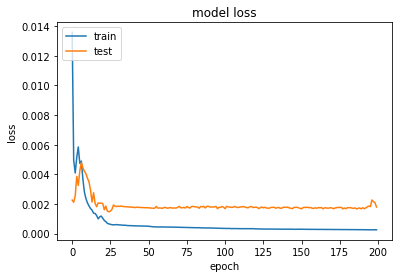

In [119]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()